In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import random
import os
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load traffic data
data = pd.read_csv("data.csv", index_col=0)
agg_mat_df = pd.read_csv("agg_mat.csv", index_col=0)

maximum = np.max(data.values)
data_scaled = (data / maximum).values

seed = 0 

def set_seeds(seed): 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # if using nvidia gpu
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

set_seeds(seed)

In [3]:
n_series = data.shape[1] 
n_total = data.shape[0]
n_train = 145
context_window = 5
n_val = 30

data.shape

(228, 555)

In [4]:
def calculate_wmape(actual_values, forecasted_values):
    # compute wMAPE metric
    n = len(actual_values)
    num = np.sum(np.abs(actual_values - forecasted_values))
    den = np.sum(np.abs(actual_values))
    wmape = num/den
    return wmape

def calculate_RMSE(actual_values, forecasted_values): 
    # compute RMSE metric
    squared_errors = (actual_values - forecasted_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

(array([-50.,   0.,  50., 100., 150., 200., 250.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250')])

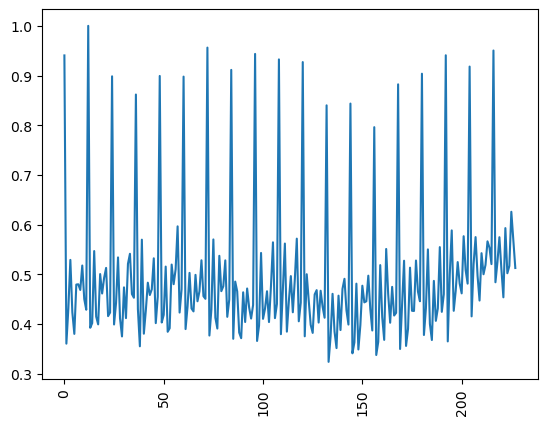

In [5]:
plt.plot(data_scaled[:,0])
plt.xticks(rotation=90)

In [6]:
def make_data(dataset, range_, context_window): 
    # produces X_data and y_data tensors given the dataset 
    X_data = []
    y_data = []
    for i in range_:
        X = dataset[i:i+context_window,:].T.flatten()
        X_data.append(X)

        y = dataset[i+context_window:i+context_window+1,:].T.flatten()
        y_data.append(y)

    return torch.tensor(X_data, dtype=float), torch.tensor(y_data, dtype=float)

In [7]:
class Dataset_Tourism(Dataset):
    def __init__(self, root_path, flag='train', data_path='data.csv', context_window=5, n_train=n_train, n_val=50, seq_len=n_train-context_window):
        
        # init
        self.root_path = root_path
        self.data_path = data_path
        self.context_window=context_window
        self.n_train = n_train
        self.n_val = n_val
        self.seq_len = seq_len
        
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path), index_col=0)
        maximum = np.max(df_raw.values)
        data = (df_raw / maximum).values
        
        X_data = []
        y_data = []

        if self.set_type == 0: 
            data_range = range(self.n_train)
        elif self.set_type == 1: 
            data_range = range(self.n_train, self.n_train + self.n_val)
        else: 
            data_range = range(self.n_train + self.n_val, self.data.shape[0] - self.context_window)

        for i in data_range:
            X = data[i:i+self.context_window,:].T.flatten()
            X_data.append(np.array(X))

            y = data[i+self.context_window:i+self.context_window+1,:].T.flatten()
            y_data.append(np.array(y))
            
        print(len(X_data))

        self.X = torch.tensor(X_data, dtype=float)
        self.y = torch.tensor(y_data, dtype=float)

    def __getitem__(self, index):
        X = self.X[index:index + self.seq_len, :]
        y = self.y[index:index + self.seq_len]
        
        return X, y

    def __len__(self):
        return len(self.X) - context_window - self.seq_len + 1

In [8]:
train_dataset = Dataset_Tourism('/home/gridsan/mhensgen/tourism/', seq_len=50)

145


/state/partition1/slurm_tmp/26011002.0.0/ipykernel_2102632/3728941026.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  self.X = torch.tensor(X_data, dtype=float)


In [9]:
train_dataset.X.dtype

torch.float64

In [10]:
X_train, y_train = make_data(data_scaled, range(n_train), context_window)
X_val, y_val = make_data(data_scaled, range(n_train, n_train+n_val), context_window)
X_test, y_test = make_data(data_scaled, range(n_train + n_val,n_total - context_window), context_window)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([145, 2775])
torch.Size([30, 2775])
torch.Size([48, 2775])


In [11]:
agg_mat_df

,AAAHol,AAAVis,AAABus,AAAOth,AABHol,AABVis,AABBus,AABOth,ABAHol,ABAVis,...,GBBBus,GBBOth,GBCHol,GBCVis,GBCBus,GBCOth,GBDHol,GBDVis,GBDBus,GBDOth
TotalAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBCOth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GBDHol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GBDVis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GBDBus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

aggregation_mat = torch.tensor(np.append(np.zeros((agg_mat_df.shape[0], agg_mat_df.shape[0] - agg_mat_df.shape[1])), agg_mat_df, axis=1), dtype=float).to(device)
S = agg_mat_df.values

def coherency_loss(network): 
    # computes coherency on last layer of the network 
    repeated_bias = network.last_layer.bias.repeat(network.last_layer.weight.shape[0], 1)
    return torch.norm(aggregation_mat @ network.last_layer.weight - network.last_layer.weight) + torch.norm(
        aggregation_mat @ repeated_bias - repeated_bias) 

def coherency_metric(predictions):
    # computes the actual coherency of predictions 
    return torch.norm(predictions.T - aggregation_mat @ predictions.T) / predictions.shape[1]

def create_M(S): 
    # creates the projection matrix M given the aggregation matrix S
    m, m_K = S.shape
    m_agg = m-m_K

    # The top `m_agg` rows of the matrix `S` give the aggregation constraint matrix.
    S_agg = S[:m_agg, :]
    A = np.hstack((np.eye(m_agg), -S_agg))

    M = np.eye(m) - A.T @ np.linalg.pinv(A @ A.T) @ A  

    return torch.from_numpy(M).float(), torch.from_numpy(A).float()


M, A = create_M(S)

def project_samples(y): 
    # project y using S (aggregation matrix )
    # y should have shape n_samples x n_series
    # y = y
    # n_samples, n_series = y.shape
    # eye = torch.eye(n_series).float()
    # eye = eye.reshape((1, n_series, n_series))
    # n_samples_eye = eye.repeat(n_samples, 1, 1)
    # Q = 2*n_samples_eye
    # G = -n_samples_eye
    # p = -2*y
    # b = torch.zeros((n_samples, A.shape[0])).float()
    # h = torch.zeros((n_samples, n_series)).float()
    # A_rep = A.repeat(n_samples, 1, 1)
    # y_proj = QPFunction(verbose=False)(Q, p, G, h, A_rep, b)

    return torch.matmul(y, M.double().to(device))


def least_squares_loss(predictions): 
    # computes the projections and then takes least squares loss between predictions and projections 
    # predictions should have shape n_samples x n_series 
    # implements coherency loss from https://www.sciencedirect.com/science/article/pii/S0306261923008747#fig5
    projections = project_samples(predictions)
    error = predictions - projections 
    square_error = torch.square(error)
    return torch.sum(square_error) / error.shape[0]


In [13]:
S.shape

(555, 304)

In [14]:
class LstmNet(nn.Module):
    def __init__(self, n_series, context, should_project=False):
        """
        n_series = number of time series we have
        context = size of context window (how many samples back we are using to predict)
        should_project: boolean determining if we use a projection before output for coherency
        """
        super().__init__()
        set_seeds(seed)
        hidden_size = int(n_series * context / 2)
        self.lstm =  nn.LSTM(input_size=n_series * context, hidden_size=hidden_size, dropout=0.2, num_layers=2, dtype=float)
        self.last_layer = nn.Linear(hidden_size, n_series, dtype=float)
        self.should_project = should_project
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(hidden_size, dtype=float)
    

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x)
        x_3d = len(x.shape) >= 3
        if x_3d: 
            x = x.transpose(1,2)
        x = self.batch_norm(x)
        if x_3d: 
            x = x.transpose(1,2)
        out = self.last_layer(x)

        if self.should_project: 
            out = project_samples(out)
            
        return out

In [15]:
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiStepLR

def train_net(n_epochs, batch_size=10, coherent=False, alpha=0, should_project=False, alpha_scaling=0, least_squares=False, scaling_increase_factor=0,
               verbose=False, should_schedule=False, plot_loss=False, lr=0.001, max_grad_norm=10): 
    """
    trains an LSTMNet on the traffic dataset based on the given parameters
    coherent: if true, uses coherent loss 
    alpha: the term we multiply the 'coherency_loss' by in calculating overall loss 
    should_project: if true, uses projection method 
    alpha_scaling: if a number, we will scale alpha by alpha_scaling * l1/l2. 
    essentially, we are setting l1 = l2*alpha, so the coherency will be weighted by 'alpha_scaling' in the loss
    """
    # sets the number of epochs we train before updating alpha 

    update_alpha_epoch = 100

    network = LstmNet(n_series, context_window, should_project=should_project)
    network = network.to(device)
    
    train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=False)

    print('--- alpha {alpha} ---- lr  {lr}----'.format(alpha=alpha, lr=lr))

    criterion = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    if should_schedule: 
        if scaling_increase_factor > 0: 
            scheduler = MultiStepLR(optimizer, milestones=[i for i in range(update_alpha_epoch + 1, n_epochs, update_alpha_epoch)], gamma=1-scaling_increase_factor)
        else: 
            scheduler = MultiStepLR(optimizer, milestones=[750, 1500, 2250], gamma=0.99)

    losses = []
    l1s = [] 
    l2s = []
    validation_loss =[] 
    
    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times

        inputs, labels = next(iter(train_dataloader))
        
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # print(inputs[0, :20, 0])
        # print(labels[0, :20, 0]) 
        # print(X_train[:20, 0]) 
        # print(y_train[:20, 0]) 

        optimizer.zero_grad()

        outputs = network(inputs)

        # add coherency network loss
        if coherent: 
            l1 = criterion(outputs, labels) 
            l2 = coherency_loss(network)

            l2s.append(l2.item())
            l1s.append(l1.item())

            loss = (l1 + alpha * l2)

            if loss.isnan(): 
                print('---')
                print(l1)
                print(l1s[epoch-5:])
                print(l2)
                print(l2s[epoch-5:])

            validation_loss.append((criterion(network(X_val.to(device)), y_val.to(device)) + alpha * l2).item())


        # normal loss
        else: 
            loss = criterion(outputs, labels)
            validation_loss.append(criterion(network(X_val.to(device)), y_val.to(device)).item())

        loss.backward()

        nn.utils.clip_grad_norm_(network.parameters(), max_grad_norm)

        optimizer.step()

        losses.append(loss.item())

        if epoch % update_alpha_epoch == 0 and epoch > 0:   
            if verbose:  
                print("Epoch:", epoch, " Loss: ", np.mean(losses))
                print(np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch])))
                print(np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch])))
            # plt.figure()
            # plt.plot(range(len(losses[epoch-100:epoch])), losses[epoch-100:epoch], label='training')
            # plt.plot(range(len(validation_loss[epoch-100:epoch])), validation_loss[epoch-100:epoch], label='validation')
            # plt.legend()
            # plt.show()

            if (coherent or least_squares) and (alpha_scaling or scaling_increase_factor > 0): 
                with torch.no_grad():
                    l1_mean = np.mean(np.array(l1s[epoch-update_alpha_epoch:epoch]))
                    l2_mean =  np.mean(np.array(l2s[epoch-update_alpha_epoch:epoch]))
                    alpha = l1_mean/l2_mean * alpha_scaling
                    alpha_scaling = alpha_scaling + scaling_increase_factor
                    if verbose: 
                        print('scaled: ', l1_mean/l2_mean)
                        print('l1 mean: ', l1_mean)
                        print('l2 mean: ', l2_mean)
                        print('alpha: ', alpha)
                        print('alpha scaling: ', alpha_scaling)

        if should_schedule: 
            scheduler.step()

            
    # plotting 
    plot_start = 0
    start_2 = 200
    if plot_loss: 
        plt.plot(range(len(losses[plot_start:])), losses[plot_start:], label='l1 + l2')
        plt.plot(range(len(losses[plot_start:])), validation_loss[plot_start:], label='val')
        plt.title('l1 starting at epoch {plot_start}'.format(plot_start=plot_start))
        plt.legend()
        plt.show()
        if coherent: 
            plt.plot(range(len(l2s[plot_start:])), l2s[plot_start:], label='l2')
            plt.title('l2 loss starting at epoch {plot_start}'.format(plot_start=plot_start))
            plt.legend() 
            plt.show()
        if start_2: 
            plt.plot(range(len(losses[start_2:])-4), [(l1s[i] + l1s[i + 1] + l1s[i + 2] + l1s[i + 3] + l1s[i + 4])/5 for i in range(start_2, len(losses)-4)], label='l1 + l2')
            plt.plot(range(len(losses[start_2:])-6), [(validation_loss[i] + validation_loss[i + 1] + validation_loss[i + 2] + validation_loss[i + 3] + validation_loss[i + 4] + validation_loss[i + 5] + validation_loss[i + 6])/7 for i in range(start_2, len(losses)-6)], label='val')
            plt.title('l1 starting at epoch {plot_start}'.format(plot_start=start_2))
            plt.legend()
            plt.show()
            if coherent: 
                plt.plot(range(len(l2s[start_2:])), l2s[start_2:], label='l2')
                plt.title('l2 loss starting at epoch {plot_start}'.format(plot_start=start_2))
                plt.legend() 
                plt.show()
    
    return network, losses


In [16]:
def visualize(ts, networks, labels, starting_zone = 0): 
    """
    Visualizes the networks' predictions on a specific time series 
    ts: time series to visualize
    labels: labels of the networks for plotting
    defining each zone as 50 points just so the graphs are easier to see 
    networks and labels should have same length
    """
    with torch.no_grad(): 
        truth = y_test.numpy()[:,ts]
        start_time = starting_zone*50
        end_time = start_time + 50
        plt.plot(truth[start_time:end_time], label = 'truth')

        for i in range(len(networks)): 
            predict_net = networks[i](X_test).numpy()[:,ts]

            plt.plot(predict_net[start_time:end_time], label = labels[i])
        plt.legend()

In [17]:
def calculate_mean_RMSE(network): 
    network.lstm.eval()  
    return calculate_RMSE(y_test.numpy(), network(X_test.to(device)).cpu().detach().numpy())


def get_metrics(networks, verbose=False): 
    rmses = []
    network_coherencies = [] 
    ll_losses = [] 
    #print(networks)
    for network in networks: 
        network.lstm.eval() 
        rmse = calculate_mean_RMSE(network)
        network_coherency = coherency_metric(network(X_test.to(device))).item() 
        ll_loss = coherency_loss(network).item()
        if verbose: 
            print("RMSE: ", rmse)
            print("Network coherency: ", network_coherency)
            print("Last Layer Coherency Loss: ", ll_loss)
        rmses.append(rmse)
        network_coherencies.append(network_coherency)
        ll_losses.append(ll_loss)
    return rmses, network_coherencies, ll_losses

In [25]:
def save_model(model, name): 
    torch.save(model.state_dict(), name + '.pth')
    
def load_model(path, should_project): 
    model = LstmNet(n_series, context_window, should_project=should_project)
    model.load_state_dict(torch.load(path,  map_location=torch.device('cpu')))
    model.to(device)
    return model 

# Baselines

In [19]:
trained_baselines = True
trained_projection = True

In [20]:
n_trials = 5

baseline_metrics = np.zeros((4, n_trials))
baseline_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_baselines: 
        baseline_network = load_model('baseline_batching_{i}.pth'.format(i=i), False)
    else:
        baseline_network, loss = train_net(1000, batch_size=25, plot_loss=True, lr=0.0005)
        save_model(baseline_network, 'baseline_batching_{i}'.format(i=i))
        
    rmse_baseline, network_coherency_baseline, network_loss_baseline = get_metrics([baseline_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), baseline_network(X_val.to(device)).detach().cpu().numpy())
    baseline_metrics[:, i] = [rmse_baseline[0], network_coherency_baseline[0], network_loss_baseline[0], validation_loss]
    baseline_networks.append(baseline_network) 

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
projection_metrics = np.zeros((4, n_trials))  
projection_networks = [] 

for i in range(n_trials): 
    seed = random.randint(0, 100) 
    if trained_projection: 
        projection_network = load_model('projection_batched_{i}.pth'.format(i=i), True)
    else: 
        projection_network, loss = train_net(1000, batch_size=25, plot_loss=True, should_project=True, lr=0.00025)
        save_model(projection_network, 'projection_batched_{i}'.format(i=i))
        
    rmse_projection, network_coherency_projection, network_loss_projection = get_metrics([projection_network], verbose=True)
    validation_loss = calculate_RMSE(y_val.numpy(), projection_network(X_val.to(device)).detach().cpu().numpy())
    projection_metrics[:, i] = [rmse_projection[0], network_coherency_projection[0], network_loss_projection[0], validation_loss]
    projection_networks.append(rmse_projection) 

In [ ]:
print(baseline_metrics.mean(axis=1)) 
print(baseline_metrics.std(axis=1)) 
print(projection_metrics.mean(axis=1))
print(projection_metrics.std(axis=1))

# Parameter Experiments 

In [27]:
alpha_experiments = [0.001, 0.01, 0.1, 1, 10]
alpha_scale_experiments = [0.05, .25, 1, 5, 20, 50]
alpha_scale_increment_experiments = [0.1, 0.5, 1, 5, 10, 50]

In [ ]:
const_alpha = 100
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))

for i in range(n_trials):
    print('----')
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_alpha_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(1000, batch_size=25, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.0005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_alpha_{inc}_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1
        
        del network
        gc.collect() 
        torch.cuda.empty_cache()

print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

In [32]:
const_alpha = 100
const_alph_scale = 0
n_trials = 4
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_scale_increment_experiments)))

for i in range(n_trials):
    print('----')
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('scaling_increment_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i), False)
        else: 
            network, loss = train_net(1000, batch_size=25, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.0005/(1 + np.log(1+scaling_increase_factor/2)), plot_loss=True)
            save_model(network, 'scaling_increment_batched_alpha_trial={i}'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1
        
        del network
        gc.collect() 
        torch.cuda.empty_cache()

print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])

----
RMSE:  0.013936079662985651
Network coherency:  0.006276169826664095
Last Layer Coherency Loss:  21.2809979348533
RMSE:  0.014533327820667259
Network coherency:  0.006143454709253568
Last Layer Coherency Loss:  15.918782021908308
RMSE:  0.014723341152784723
Network coherency:  0.005247704713978316
Last Layer Coherency Loss:  13.391622386517092
RMSE:  0.014877464259722611
Network coherency:  0.0029245415809769854
Last Layer Coherency Loss:  6.578855394506436
RMSE:  0.013663140544910206
Network coherency:  0.0015884262495399497
Last Layer Coherency Loss:  3.3219806802465035
RMSE:  0.013764176938040596
Network coherency:  0.0014771658064856147
Last Layer Coherency Loss:  0.15689233733275748
----
RMSE:  0.014160547593307773
Network coherency:  0.006363242876805543
Last Layer Coherency Loss:  21.23233105776967
RMSE:  0.014412333925148893
Network coherency:  0.005742931499046599
Last Layer Coherency Loss:  15.913921600285818
RMSE:  0.014398577902098034
Network coherency:  0.005143582401

In [33]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])
print(metrics_increment.std(axis=1)[1, :])

test
[0.0140709  0.014279   0.01466549 0.01467479 0.01413995 0.01363991]
[9.53430701e-05 1.99373932e-04 3.50153750e-04 1.55517704e-04
 3.30323813e-04 1.56687534e-04]
validation
[0.00868301 0.00865824 0.00892856 0.00850059 0.00803928 0.00782088]
[2.76636224e-04 1.36185552e-04 3.22118997e-04 1.94231001e-04
 7.86087659e-05 5.64408307e-05]
coherency
[0.00629    0.00588382 0.00521062 0.00297094 0.00157502 0.00077735]
[4.41848288e-05 1.56052908e-04 6.55833669e-05 3.70383445e-05
 5.98140778e-05 5.47916855e-04]


In [ ]:
def print_memory(): 
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(t, r, a)

In [ ]:
print_memory()

In [ ]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
proj_inc_trained = True

metrics_project_increment = np.zeros((3, n_trials, len(alpha_scale_increment_experiments)))
#networks_project_increment = [[] for i in range(n_trials)]

for i in range(n_trials):  
    scaling_idx = 0 
    for scaling_increase_factor in alpha_scale_increment_experiments: 
        if proj_inc_trained: 
            network = load_model('projection_inc_batched_{inc}_trial={i}.pth.pth'.format(inc=scaling_increase_factor, i=i), True)
        else: 
            network, loss = train_net(1000, batch_size=25, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, should_project=True,
                                 scaling_increase_factor=scaling_increase_factor, 
                                 lr=0.005/(1 + np.log(1+scaling_increase_factor/4)), plot_loss=True)
            save_model(network, 'projection_inc_batched_{inc}_trial={i}.pth'.format(inc=scaling_increase_factor, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_project_increment[0, i, scaling_idx] = rmse[0] 
        metrics_project_increment[1, i, scaling_idx] = validation_loss
        metrics_project_increment[2, i, scaling_idx] = coherency[0]
        #networks_project_increment[i].append(network)
        
        scaling_idx += 1
        
metrics_project_increment.mean(axis=1), metrics_project_increment.std(axis=1)

In [ ]:
print('test')
print(metrics_project_increment.mean(axis=1)[0, :])
print(metrics_project_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_project_increment.mean(axis=1)[1, :])
print(metrics_project_increment.std(axis=1)[1, :])
print('coherency') 
print(metrics_project_increment.mean(axis=1)[2, :])

In [28]:
const_alpha = 0
const_alph_scale = 0
n_trials = 5
alpha_inc_experiments_trained = True

metrics_increment = np.zeros((4, n_trials, len(alpha_experiments)))

for i in range(n_trials):  
    scaling_idx = 0 
    for alpha in alpha_experiments: 
        if alpha_inc_experiments_trained: 
            network = load_model('alpha_{alpha}_trial={i}.pth'.format(alpha=alpha, i=i), False)
        else: 
            network, loss = train_net(1000, batch_size=25, coherent=True, alpha=alpha, alpha_scaling=const_alph_scale, should_project=False,
                                 scaling_increase_factor=5, 
                                 lr=0.005/(1 + np.log(1+alpha)), plot_loss=True)
            save_model(network, 'alpha_{alpha}_trial={i}'.format(alpha=alpha, i=i))
            
        rmse, coherency, network_loss = get_metrics([network], verbose=True)
        validation_loss = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        metrics_increment[:, i, scaling_idx] = [rmse[0], coherency[0], network_loss[0], validation_loss]
        
        scaling_idx += 1

metrics_increment.mean(axis=1), metrics_increment.std(axis=1)

RMSE:  0.00801964797814301
Network coherency:  0.01163829196233241
Last Layer Coherency Loss:  2.338877797375149
RMSE:  0.008782075902033197
Network coherency:  0.0215207585173377
Last Layer Coherency Loss:  0.5617629265520871
RMSE:  0.00839498508463038
Network coherency:  0.0012960302133732137
Last Layer Coherency Loss:  2.0939197430738234
RMSE:  0.00976812328485328
Network coherency:  0.012878966208054704
Last Layer Coherency Loss:  1.5098113205610646
RMSE:  0.009436652908927727
Network coherency:  0.0006336814332317253
Last Layer Coherency Loss:  0.3715310870064088
RMSE:  0.09147431084699824
Network coherency:  0.565064448941232
Last Layer Coherency Loss:  8.360082546410988
RMSE:  0.009642978802497147
Network coherency:  0.0042825139101230255
Last Layer Coherency Loss:  3.3154933111311413
RMSE:  0.009441054132609837
Network coherency:  0.00037466660817381915
Last Layer Coherency Loss:  0.5978347437472771
RMSE:  0.007578881365072924
Network coherency:  0.00019335832319822662
Last Lay

(array([[4.27070547e-02, 1.27821743e-02, 9.24246317e-03, 8.83755983e-03,
         1.02002939e-02],
        [2.38905988e-01, 3.91174929e-02, 8.71425297e-04, 1.43733044e-02,
         1.02974173e-02],
        [6.91018324e+00, 1.99154684e+00, 1.31443860e+00, 2.13854392e+00,
         4.31125008e-01],
        [5.12316024e-02, 1.53776691e-02, 8.09651489e-03, 7.52034372e-03,
         7.17072020e-03]]),
 array([[3.45324622e-02, 6.64612499e-03, 4.23830431e-04, 1.07175812e-03,
         4.43745555e-04],
        [2.35045893e-01, 5.80120537e-02, 3.26077455e-04, 1.34207236e-02,
         1.18450252e-02],
        [2.31585508e+00, 1.41395081e+00, 5.47811397e-01, 1.71746652e+00,
         1.33782337e-01],
        [3.31238920e-02, 6.94478865e-03, 1.23023209e-03, 1.33536092e-03,
         5.94192240e-04]]))

In [31]:
print('test')
print(metrics_increment.mean(axis=1)[0, :])
print(metrics_increment.std(axis=1)[0, :])
print('validation') 
print(metrics_increment.mean(axis=1)[3, :])
print(metrics_increment.std(axis=1)[3, :])
print('coherency') 
print(metrics_increment.mean(axis=1)[1, :])
print(metrics_increment.std(axis=1)[1, :])

test
[0.04270705 0.01278217 0.00924246 0.00883756 0.01020029]
[0.03453246 0.00664612 0.00042383 0.00107176 0.00044375]
validation
[0.0512316  0.01537767 0.00809651 0.00752034 0.00717072]
[0.03312389 0.00694479 0.00123023 0.00133536 0.00059419]
coherency
[0.23890599 0.03911749 0.00087143 0.0143733  0.01029742]
[0.23504589 0.05801205 0.00032608 0.01342072 0.01184503]


In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_scale_increment = [train_net(10000, coherent=True, alpha=const_alpha, alpha_scaling=const_alph_scale, 
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1 + scaling_increase_factor/4)), 
                                      plot_loss=True) for scaling_increase_factor in [10]]

get_metrics(networks_scale_increment, verbose=True)

In [ ]:
mean_rmses_if = np.mean(metrics_increment[0], axis=0)
std_rmses_if = np.std(metrics_increment[0], axis=0)

print(mean_rmses_if)
print(std_rmses_if) 

mean_network_coherencies_if = np.mean(metrics_increment[1], axis=0)
std_network_coherencies_if = np.std(metrics_increment[1], axis=0)

mean_ll_losses_if = np.mean(metrics_increment[2], axis=0)
std_ll_losses_if = 2*np.std(metrics_increment[2], axis=0)

print(mean_network_coherencies_if)
print(std_network_coherencies_if) 

# Calculate mean and std for baseline and projection metrics
mean_metrics_baseline = np.mean(baseline_metrics, axis=1)
std_metrics_baseline = 2*np.std(baseline_metrics, axis=1)

mean_metrics_projection = np.mean(projection_metrics, axis=1)
std_metrics_projection = 2*np.std(projection_metrics, axis=1)

print(mean_metrics_baseline)
print(std_metrics_baseline)
print(mean_metrics_projection)
print(std_metrics_projection) 

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))

# RMSE plot with error bars
ax1.set_title('RMSE vs alpha scaling increment')
ax1.errorbar(alpha_scale_increment_experiments, mean_rmses_if, yerr=std_rmses_if, fmt='o', label='Incremental')
ax1.axhline(mean_metrics_baseline[0], color='red', label='Baseline', linestyle='--')
ax1.axhline(mean_metrics_projection[0], color='blue', label='Projection', linestyle='--')
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_baseline[0]-std_metrics_baseline[0], mean_metrics_baseline[0]+std_metrics_baseline[0], color='red', alpha=0.2)
ax1.fill_between([min(alpha_scale_increment_experiments), max(alpha_scale_increment_experiments)], mean_metrics_projection[0]-std_metrics_projection[0], mean_metrics_projection[0]+std_metrics_projection[0], color='blue', alpha=0.2)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('Alpha')
ax1.legend()

# Network coherency plot with error bars
ax2.set_title('Coherency on data vs alpha, incremental')
ax2.errorbar(alpha_scale_increment_experiments, mean_network_coherencies_if, yerr=std_network_coherencies_if, fmt='o')
ax2.set_ylabel('Coherency on data')
ax2.set_xlabel('Alpha')

# Last layer coherency plot with error bars
ax3.errorbar(alpha_scale_increment_experiments, mean_ll_losses_if, yerr=std_ll_losses_if, fmt='o')
ax3.set_ylabel('Last layer coherency')
ax3.set_xlabel('Alpha')

plt.tight_layout()
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_project = [train_net(6000, coherent=True, alpha=0, alpha_scaling=0, should_project=True, plot_loss=True,
                            scaling_increase_factor=scaling_increase_factor, lr=0.005/(1 + np.log(1+scaling_increase_factor/4))) for scaling_increase_factor in alpha_scale_increment_experiments]

get_metrics(networks_project, verbose=True)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))
ax1.set_title('metrics vs alpha scaling increment with projection')
ax1.scatter(alpha_scale_experiments, rmses_if)
ax1.axhline(rmse_baseline, color='red', label='baseline')
ax1.axhline(rmse_projection, color='green', label='projection')
ax1.set_ylabel('rmse')
ax1.set_xlabel('alpha')
ax1.legend()
#ax2.set_title('coherency on data vs alpha, no scaling and no scaling increment')
ax2.scatter(alpha_scale_experiments, network_coherencies_if)
ax2.set_ylabel('coherency on data')
ax2.set_xlabel('alpha')
#ax3.set_title('last layer coherency vs alpha, no scaling and no scaling increment')
ax3.scatter(alpha_scale_experiments, ll_losses_if)
ax3.set_ylabel('last layer coherency')
ax3.set_xlabel('alpha')
plt.show()

In [ ]:
#network, losses = train_net(1000, coherent=False) 
#network_coherent, losses_coherent = train_net(1000, coherent=True, alpha=0)
#network_coherent_high_scaling, losses_coherent_high_scaling = train_net(1000, coherent=True, alpha=0.25, alpha_scaling=1)
network_projection, losses_projection = train_net(5000, should_project=True)
#network_coherent_and_projecting, losses_projection_high_scaling = train_net(1000, coherent=True, alpha=0.5, alpha_scaling=1, should_project=True)

In [ ]:
plt.plot(range(len(losses_projection[100:])), losses_projection[100:], label='projection')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.figure()
#plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
#plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
#plt.legend() 

In [ ]:
rmse_projection = calculate_mean_RMSE(network_projection)
rmse_projection

In [ ]:
rmse_projection = 0.0032 

In [ ]:
network_baseline, losses_baseline = train_net(2000, coherent=False)

In [ ]:
rmse_baseline = calculate_mean_RMSE(network_baseline)
rmse_baseline

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Labour Dataset')

# First Set of Data
axs[0, 0].set_title('Alpha Experiments (No Scaling and No Scaling Increment)')
axs[0, 0].scatter(alpha_experiments, rmses)
axs[0, 0].set_ylabel('rmse')
axs[0, 0].set_xlabel('alpha')
axs[0, 0].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 0].axhline(rmse_projection, color='green', label='projection')
axs[0, 0].legend()

axs[1, 0].scatter(alpha_experiments, network_coherencies)
axs[1, 0].set_ylabel('coherency on data')
axs[1, 0].set_xlabel('alpha')
axs[1, 0].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 0].legend()

axs[2, 0].scatter(alpha_experiments, ll_losses)
axs[2, 0].set_ylabel('last layer coherency')
axs[2, 0].set_xlabel('alpha')

# Second Set of Data
axs[0, 1].set_title('Alpha Scaling Experiments (Constant alpha = 0)')
axs[0, 1].scatter(alpha_scale_experiments, rmses_s)
axs[0, 1].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 1].axhline(rmse_projection, color='green', label='projection')
axs[0, 1].set_ylabel('rmse')
axs[0, 1].set_xlabel('alpha scaling')
axs[0, 1].legend()

axs[1, 1].scatter(alpha_scale_experiments, network_coherencies_s)
axs[1, 1].set_ylabel('coherency on data')
axs[1, 1].set_xlabel('alpha scaling')
axs[1, 1].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 1].legend()

axs[2, 1].scatter(alpha_scale_experiments, ll_losses_s)
axs[2, 1].set_ylabel('last layer coherency')
axs[2, 1].set_xlabel('alpha scaling')

# Third Set of Data
axs[0, 2].set_title('Scaling Increment Experiments (Constant alpha = 0, scaling = 0)')
axs[0, 2].scatter(alpha_scale_increment_experiments, rmses_if)
axs[0, 2].axhline(rmse_baseline, color='red', label='baseline')
axs[0, 2].axhline(rmse_projection, color='green', label='projection')
axs[0, 2].set_ylabel('rmse')
axs[0, 2].set_xlabel('alpha increment')
axs[0, 2].legend()

axs[1, 2].scatter(alpha_scale_increment_experiments, network_coherencies_if)
axs[1, 2].set_ylabel('coherency on data')
axs[1, 2].set_xlabel('alpha increment')
axs[1, 2].axhline(network_coherency_baseline, color='red', label='baseline')
axs[1, 2].legend()

axs[2, 2].scatter(alpha_scale_increment_experiments, ll_losses_if)
axs[2, 2].set_ylabel('last layer coherency')
axs[2, 2].set_xlabel('alpha increment')

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[0,2].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')
axs[1,2].set_xscale('log')
axs[2,0].set_xscale('log')
axs[2,1].set_xscale('log')
axs[2,2].set_xscale('log')

plt.tight_layout()
plt.savefig('parameter_experiments_traffic.png')
plt.show()

In [ ]:
const_alpha = 0
const_alph_scale = 0

networks_increment_scaled = [train_net(4000, coherent=True, alpha=0, alpha_scaling=0, should_project=True,
                            scaling_increase_factor=scaling_increase_factor + 0.1, lr=0.005/(1 + np.log(1+scaling_increase_factor))) for scaling_increase_factor in alpha_scale_experiments]

get_metrics(networks_increment_scaled, verbose=True)

In [ ]:
# TODO: implement a function that chooses alpha based on the best training data and hopefully show that the selected alpha also performs well on test data

def test_best_alpha(networks):

    train_rmses = [] 
    test_rmses = [] 

    for network, _ in networks: 

        network.lstm.eval() 
        train_rmse = calculate_RMSE(y_val.numpy(), network(X_val.to(device)).detach().cpu().numpy())
        test_rmse = calculate_RMSE(y_test.numpy(), network(X_test.to(device)).detach().cpu().numpy())

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    return train_rmses, test_rmses

In [ ]:
train_rmses, test_rmses = test_best_alpha(networks_scale_increment)
#train_rmses_scaled, test_rmses_scaled = test_best_alpha(networks_increment_scaled)
# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(train_rmses, test_rmses)

plt.axhline(rmse_projection, color='green', label='projection')
plt.axhline(rmse_baseline, color='red', label='baseline')

# Annotate each point with its label
for i, label in enumerate(alpha_scale_increment_experiments):
    plt.annotate(label, (train_rmses[i], test_rmses[i]), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize the plot
plt.title('Test RMSE vs. Validation RMSE. Labels are Alpha Scaling Increment Values')
plt.xlabel('Validation RMSE')
plt.ylabel('Test RMSE')

# # Set custom axis limits
# plt.xlim(0.0010, 0.0013)
# plt.ylim(0.004, 0.0055)

# Show the plot
plt.legend() 
plt.savefig('val_traffic.png')
plt.show()

In [ ]:
test_best_alpha(networks)

In [ ]:
# plot losses for learning
#plt.plot(range(len(losses[100:])), losses[100:], label='base')
plt.plot(range(len(losses_projection[100:1000])), losses_projection_high_scaling[100:1000], label='projection')
plt.legend()
plt.show()
plt.figure()
plt.plot(range(len(losses_coherent[101:])), losses_coherent[101:], label='coherent')
plt.plot(range(len(losses_coherent_high_scaling[101:])), losses_coherent_high_scaling[101:], label='high scaling')
plt.legend() 

In [ ]:
# printing the real coherency of each network we trained
print("baseline network coherency", coherency_metric(network(X_test)).item())
print("coherent network coherency", coherency_metric(network_coherent(X_test)).item())
print("coherent network coherency (high scaling)", coherency_metric(network_coherent_high_scaling(X_test)).item())
#print("projection network coherency", coherency_metric(network_projection(X_test)).item())
#print("both coherency", coherency_metric(network_coherent_and_projecting(X_test)).item())

In [ ]:
n_iters = 20

def calculate_mean_RMSE(network, n_iters=n_iters): 
    errs = np.zeros((n_iters, )) 
    for i in range(n_iters): 
        errs[i] = calculate_RMSE(y_test.numpy(), network(X_test).detach().numpy())
    return np.mean(errs)

print("RMSE Baseline:", calculate_mean_RMSE(network))
print("RMSE Coherent:", calculate_mean_RMSE(network_coherent))
print("RMSE Coherent (high scaling):", calculate_mean_RMSE(network_coherent_high_scaling))
print("RMSE Projection:", calculate_mean_RMSE(network_projection))
print("RMSE Both:", calculate_mean_RMSE(network_coherent_and_projecting))

In [ ]:
print("WMAPE Baseline:", calculate_wmape(y_test.numpy(), network(X_test).detach().numpy()))
print("WMAPE Coherent:", calculate_wmape(y_test.numpy(), network_coherent(X_test).detach().numpy()))
print("WMAPE Coherent (high scaling):", calculate_wmape(y_test.numpy(), network_coherent_high_scaling(X_test).detach().numpy()))
print("WMAPE Projection:", calculate_wmape(y_test.numpy(), network_projection(X_test).detach().numpy()))
print("WMAPE Both:", calculate_wmape(y_test.numpy(), network_coherent_and_projecting(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Baseline:", coherency_loss(network).item())
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_coherent).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_coherent_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())
print("Last Layer Coherency Loss Both:", coherency_loss(network_coherent_and_projecting).item())

## Least Squares Loss

In [ ]:
# training 'least squares loss' networks 
network_ls, loss_ls = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=1)
network_ls_high_scaling, loss_ls_high_scaling = train_net(500, least_squares=True, alpha=0.5, alpha_scaling=5)

In [ ]:
# printing the real coherency of each network we trained
print("MSE_loss network coherency", coherency_metric(network_ls(X_test)).item())
print("MSE_loss high scaling network coherency", coherency_metric(network_ls_high_scaling(X_test)).item())
print("MSE_loss and project coherency", coherency_metric(network_ls_and_project(X_test)).item())

In [ ]:
# printing the real coherency of each network we trained
print("baseline network RMSE", calculate_RMSE(y_test.numpy(), network_ls(X_test).detach().numpy()))
print("coherent network RMSE", calculate_RMSE(y_test.numpy(), network_ls_high_scaling(X_test).detach().numpy()))
print("coherent network coherency (high scaling) RMSE", calculate_RMSE(y_test.numpy(), network_ls_and_project(X_test).detach().numpy()))

In [ ]:
print("Last Layer Coherency Loss Coherent:", coherency_loss(network_ls).item())
print("Last Layer Coherency Loss Coherent (high scaling):", coherency_loss(network_ls_high_scaling).item())
print("Last Layer Coherency Loss Projection:", coherency_loss(network_projection).item())

In [ ]:
visualize(0, [network, network_coherent, network_projection], ['baseline', 'coherent loss', 'projection'])

In [ ]:
all_agg_levels = np.unique([torch.sum(aggregation_mat[ts,:]).item() for ts in range(len(aggregation_mat))])

In [ ]:
all_agg_levels

In [ ]:
# this code plots the error 

aggregation_level = all_agg_levels[0]
aggregation_amounts = []
errs_baseline = [] 
errs_coherent = []
for ts in range(len(aggregation_mat)):
    agg_level = torch.sum(aggregation_mat[ts,:]).item()
    if agg_level == aggregation_level: 
        err_baseline = torch.norm(network(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)
        err_coherent = torch.norm(network_coherent(X_test)[:,ts] - y_test[:,ts]).item() / len(X_test)

        aggregation_amounts.append(agg_level)
        errs_baseline.append(err_baseline)
        errs_coherent.append(err_coherent)

plt.hist([errs_baseline, errs_coherent], label = ['projection', 'coherent'])

print("Baseline:", np.mean(errs_baseline))
print("Coherent:", np.mean(errs_coherent))

plt.xlabel('|y_pred - y|/N')
plt.legend()